In [12]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
!jupyter nbconvert --to script dqn.ipynb


[NbConvertApp] Converting notebook dqn.ipynb to script
[NbConvertApp] Writing 14231 bytes to dqn.py


In [13]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        # deque: Doubly Ended Queue
    
    def push(self, *args):
        '''Save a transition'''
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [89]:
env = gym.make('CartPole-v0')
env.reset()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [52]:
# transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = T.Compose([T.ToTensor()])
'''
ToTensor():
Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
'''

def get_screen():
    rgb_array = env.render(mode='rgb_array').copy()
    assert rgb_array.shape == (400, 600, 3)
    return transform(rgb_array).unsqueeze(0)
    

In [54]:
get_screen().shape

torch.Size([1, 3, 400, 600])

In [55]:
class DQN(nn.Module):
    '''
    conv2d: (N, C, H, W) -> (N, C_out, H_out, W_out)
    '''
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [56]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0

In [79]:
i = torch.randn(1,3,400,600)
policy_net(i)

tensor([[-0.7257, -0.2800]], grad_fn=<AddmmBackward>)

In [88]:
policy_net(i).max(1)[1].item()

1

In [86]:
def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp()
    steps_done += 1
    if random.random() >= eps_threshold:
        return policy_net(i).max(1)[1].view(1,1) # Use policy net here...to decide best action so far
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [90]:
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [1]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions)) # concatenated along field axes
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

In [92]:
memory.push(torch.randn(1,3,400,600), 0, torch.randn(1,3,400,600), 1)
memory.push(torch.randn(1,3,400,600), 0, torch.randn(1,3,400,600), 1)
memory.push(torch.randn(1,3,400,600), 0, torch.randn(1,3,400,600), 1)
memory.push(torch.randn(1,3,400,600), 0, torch.randn(1,3,400,600), 1)

In [96]:
transitions = memory.sample(2)

In [102]:
Transition(*zip(*transitions)).next_state[1]

tensor([[[[ 2.9359, -0.3254,  1.1391,  ...,  1.3141,  0.6495,  0.6963],
          [ 1.1139,  2.3185,  1.7724,  ...,  0.0150,  0.3312,  0.4021],
          [ 0.4719, -0.0532,  0.8404,  ...,  1.9888,  0.6709,  0.5119],
          ...,
          [-0.5857,  0.1363, -0.2422,  ..., -1.0092, -1.4454,  0.2368],
          [ 0.5230,  0.3253,  0.3292,  ..., -1.0470, -0.1470, -0.1809],
          [-1.1985,  1.1009,  0.8172,  ...,  0.2116,  1.9131,  1.7149]],

         [[-0.3002, -0.3937, -1.3914,  ...,  0.2192,  0.2968, -1.1763],
          [-0.9238,  1.7163,  0.4355,  ...,  0.3918, -1.4436, -1.3221],
          [-0.1748, -0.8825,  1.0331,  ...,  0.2434,  0.4167,  1.0066],
          ...,
          [-0.7874,  1.0651,  0.5141,  ..., -0.0892,  0.6730,  0.8772],
          [ 0.3241, -0.4011,  0.3797,  ..., -0.0469, -0.0869,  0.1214],
          [-1.1057,  0.5016,  1.2020,  ..., -0.3370,  0.5300, -0.7840]],

         [[ 0.3869, -0.0559,  0.8213,  ..., -0.0308,  1.3288, -0.3785],
          [-0.1517,  1.1028,  

In [ ]:
num_episodes = 50

for i_episode in range(num_episodes):
    env.reset()
    
    state = get_screen() - get_screen() # dummy state
    t = 0
    while True:
        action = select_action(state)
        
        previous_screen = get_screen()
        _, reward, done, _ = env.step(action.item())
        
        if not done:
            next_state = get_screen() - previous_screen
        else:
            next_state = None
        
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
        
        t += 1
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
            
        

In [2]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

/Users/peter/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.00300323, -0.02719453,  0.00857147,  0.03419161])

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        # deque: Doubly Ended Queue
    
    def push(self, *args):
        '''Save a transition'''
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [8]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

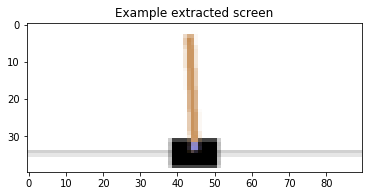

In [9]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [19]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [1]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(300):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.render()
env.close()

/Users/peter/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/peter/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


asdasd


In [2]:
import gym
env = gym.make('CartPole-v0')
env.reset()

/Users/peter/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.0387599 , -0.00171925,  0.02549799,  0.02399171])

In [16]:
env.reset()
a = env.render(mode='rgb_array')
env.close()

In [18]:
a.shape

(400, 600, 3)

In [28]:
env.reset()

array([0.03641905, 0.00716659, 0.00335491, 0.03700209])

In [23]:
env.action_space.sample()

1

In [24]:
env.step(0)

(array([-0.03927384, -0.17772464, -0.04752022,  0.29644946]), 1.0, False, {})

In [25]:
env.observation_space

Box(4,)

In [26]:
print(env.observation_space.high)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [27]:
print(env.observation_space.low)


[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [29]:
# [position of cart, velocity of cart, angle of pole, rotation rate of pole]